In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [2]:
data_path = "../data/data.npz"
data = np.load(data_path)

data_ai_path = "../data/data_ai.npz"
data_ai = np.load(data_ai_path)

X = np.concatenate([data["data"], data_ai["data"]], axis = 0)
target = np.concatenate([data["target"], data_ai["target"]], axis = 0)

In [3]:
X.shape

(158, 128, 128)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3)

X_train_tensor = torch.tensor(X_train).view(-1,1,128,128)
y_train_tensor = torch.tensor(y_train)

X_test_tensor = torch.tensor(X_test).view(-1,1,128,128)
y_test_tensor = torch.tensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [5]:
class CNN(nn.Module):
    def __init__(self, number_of_emotions = 4):
        super(CNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, kernel_size=5, padding=2),  # Adjust based on your input 64x64
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # nn.Conv2d(8, 16, kernel_size=3, padding=1),  # Adjust based on your input 64x64
            # nn.ReLU(),
            # nn.MaxPool2d(2, 2),
        )

        self.fc1 = nn.Linear(16 * 32 * 32, 64)  # Adjust this
        self.dropout = nn.Dropout(p = 0.35)
        self.fc2 = nn.Linear(64, number_of_emotions)  # Adjust number_of_emotions based on your data

    def forward(self, x):
        x = self.conv_layers(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
model = CNN()
sum(p.numel() for p in model.parameters())

1052324

In [6]:
N, C, W, H = X_train_tensor.shape
N_test = y_test_tensor.shape[0]

n_epoch = 100
batch_size = 16

model = CNN()
optimizer = optim.Adam(model.parameters(), lr = 3e-4)
criterion = nn.CrossEntropyLoss(reduction="sum")

device = "cuda" if torch.cuda.is_available() else "cpu"

X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

model.to(device)
for epoch in range(100):
    model.train()
    running_loss = .0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(X_batch.float())

        loss = criterion(y_pred, y_batch.to(torch.long))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss = loss.item()
    
    running_loss /= N

    with torch.no_grad():
        predictions = model(X_test_tensor.float())
        pred_class = torch.argmax(predictions, axis = 1)
        test_acc = (pred_class == y_test_tensor).float().mean()
        test_loss = criterion(predictions, y_test_tensor.long()).item() / N_test

    if test_acc >= 0.7:
        print(f"Epoch: {epoch+1:>2}, Train loss: \033[92m{running_loss:.4f}\033[0m, Test loss: \033[94m{test_loss:.4f}\033[0m, Test accuracy: \033[92m{test_acc:.4f}\033[0m.")
    elif test_acc < 0.5:
        print(f"Epoch: {epoch+1:>2}, Train loss: \033[92m{running_loss:.4f}\033[0m, Test loss: \033[94m{test_loss:.4f}\033[0m, Test accuracy: \033[91m{test_acc:.4f}\033[0m.")
    else:
        print(f"Epoch: {epoch+1:>2}, Train loss: \033[92m{running_loss:.4f}\033[0m, Test loss: \033[94m{test_loss:.4f}\033[0m, Test accuracy: \033[94m{test_acc:.4f}\033[0m.")


Epoch:  1, Train loss: 0.0773, Test loss: 1.4088, Test accuracy: 0.1875.
Epoch:  2, Train loss: 0.0755, Test loss: 1.3954, Test accuracy: 0.2083.
Epoch:  3, Train loss: 0.0764, Test loss: 1.3917, Test accuracy: 0.1875.
Epoch:  4, Train loss: 0.0727, Test loss: 1.4009, Test accuracy: 0.2083.
Epoch:  5, Train loss: 0.0702, Test loss: 1.3649, Test accuracy: 0.3125.
Epoch:  6, Train loss: 0.0796, Test loss: 1.3722, Test accuracy: 0.3542.
Epoch:  7, Train loss: 0.0623, Test loss: 1.3249, Test accuracy: 0.3542.
Epoch:  8, Train loss: 0.0800, Test loss: 1.1991, Test accuracy: 0.4792.
Epoch:  9, Train loss: 0.0560, Test loss: 1.1947, Test accuracy: 0.5000.
Epoch: 10, Train loss: 0.0611, Test loss: 1.1984, Test accuracy: 0.4583.
Epoch: 11, Train loss: 0.0355, Test loss: 1.0533, Test accuracy: 0.4583.
Epoch: 12, Train loss: 0.0437, Test loss: 1.1386, Test accuracy: 0.5625.
Epoch: 13, Train loss: 0.0347, Test loss: 1.0602, Test accuracy: 0.5208.
Epoch: 14, Train loss: 0.0589, Test loss: 0.9892, T

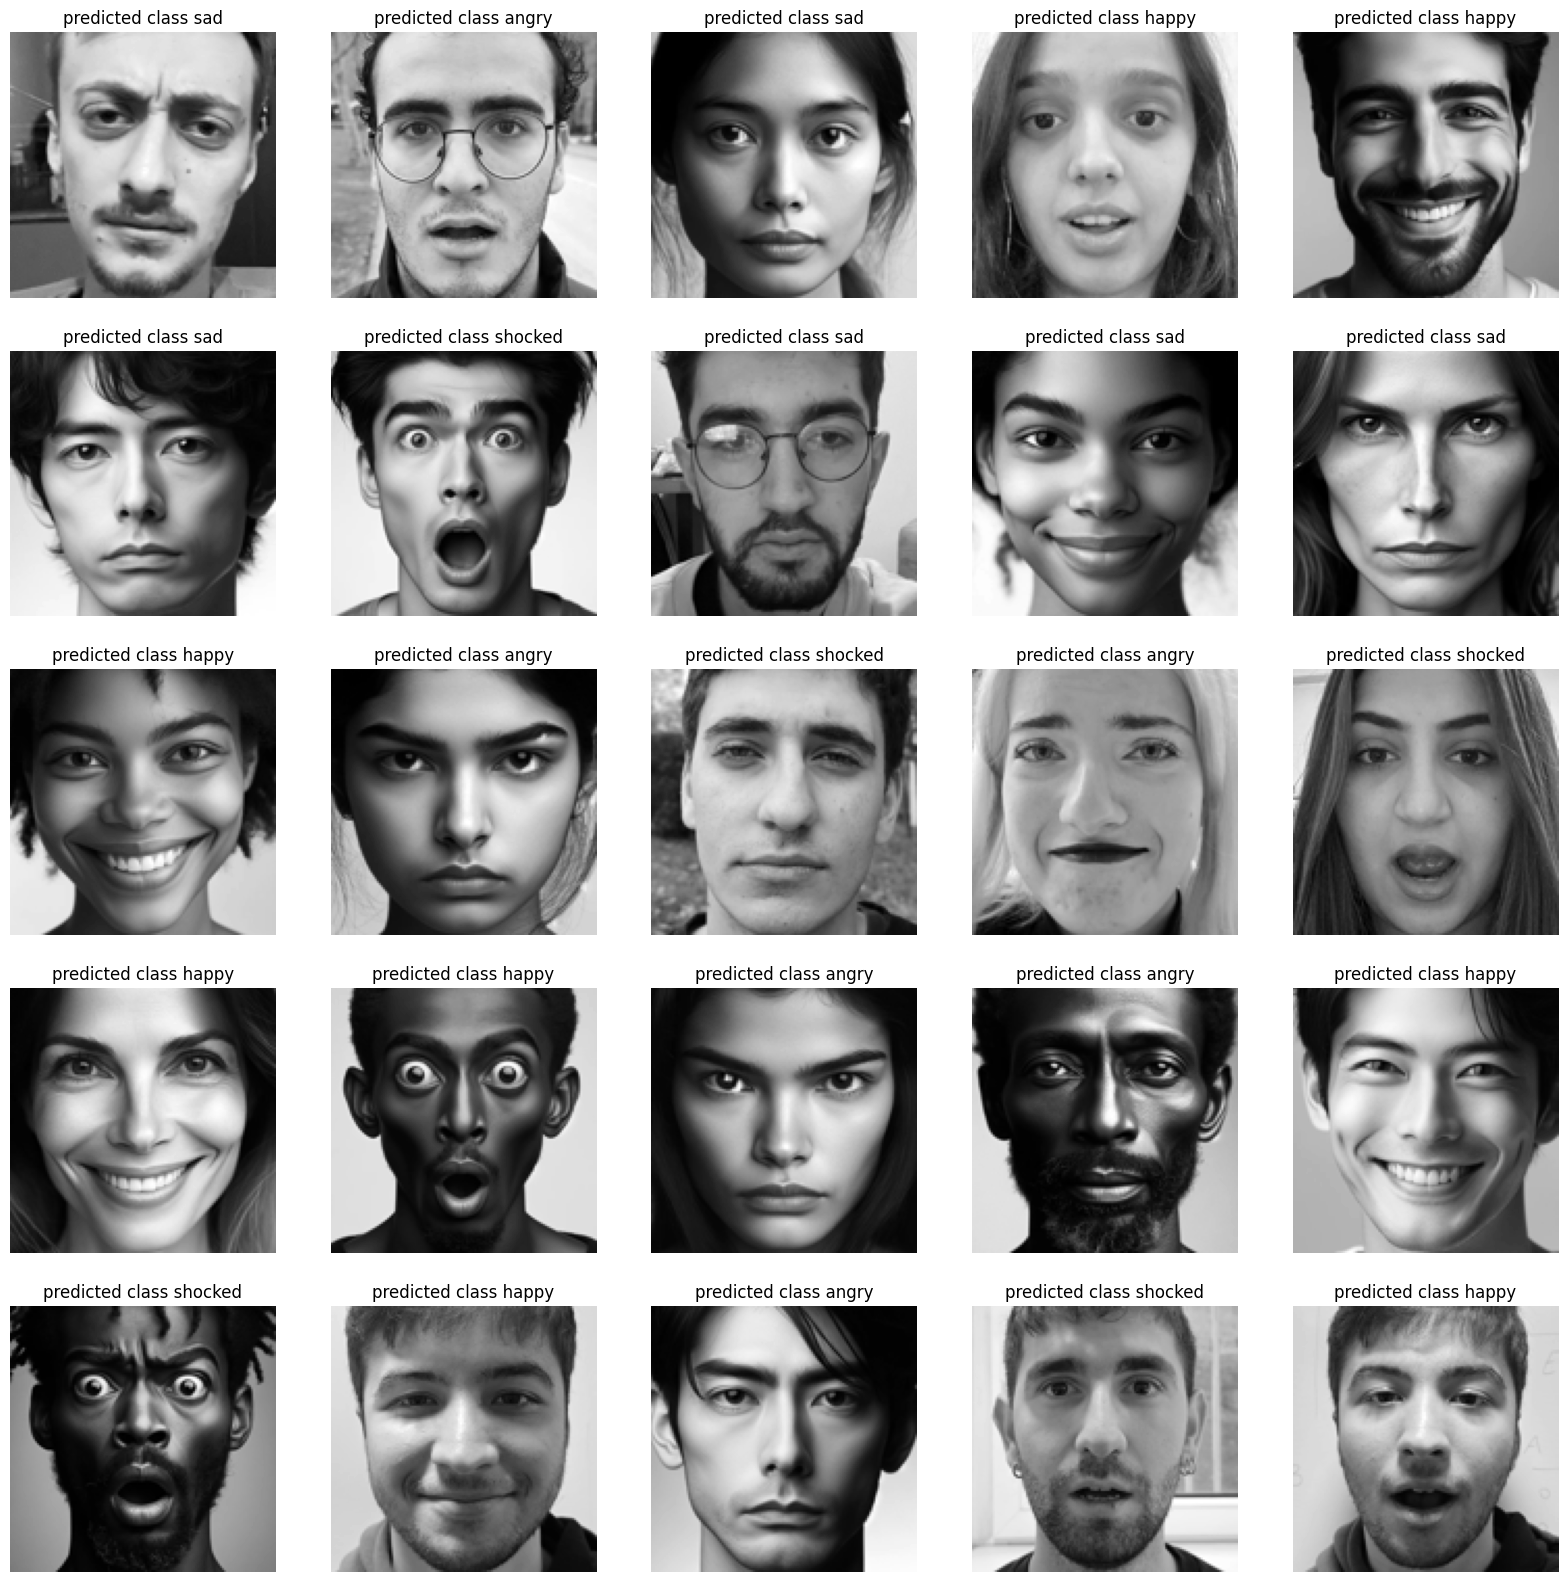

In [24]:
emotion_map = {0.:"sad", 1.:"angry", 2.:"shocked", 3.:"happy"}

predictions = model(X_test_tensor.float()).argmax(axis = 1)


fig, axs = plt.subplots(5, 5, figsize=(20, 20))

axs = axs.flatten()
# Loop through each image and plot it
for i in range(25):
    axs[i].imshow(X_test_tensor[i].cpu().squeeze(), cmap='gray')  # Assuming grayscale images
    axs[i].axis('off')  # Turn off axis labels
    axs[i].set_title(f"predicted class {emotion_map[int(predictions[i])]}")  # Add a title for each subplot

plt.show()